In [1]:
# for each site: 1 channel and 1 ground truth
# sort waves by height, pick test and train from each
# calc waves using CF calculated from each range
# Calculate waves from correction factor at each site

import numpy as np
import oceanDAS as odas
import h5py
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal
import xarray as xr

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

# load depth, noise floor, and color for each site (In order of table 1)
h, f_noise, clrs = odas.all_line_info()


In [2]:
# # calculate and compare wave stats for Homer
# pname = 'HomerAK_Williams/'

# # load ground truth spectra:
# with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
#     sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
#     sfreq = fp['FREQ'][:] # Hz
#     sspec = fp['SPEC'][:] # m^2/Hz
# nt = len(sdate)     # number of buoy spectra

# # calculate wave stats from spectra for comparison:
# hs_hombuoy = np.zeros(nt)
# tp_hombuoy = np.zeros(nt)
# te_hombuoy = np.zeros(nt)
# for jj in range(nt):
#     ds_psd_corr = sspec[jj,(sfreq > 0.04) & (sfreq < 0.3)]
#     f_psd = sfreq[(sfreq > 0.04) & (sfreq < 0.3)]
#     fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
#     te_hombuoy[jj] = 1/fe
#     tp_hombuoy[jj] = 1/(f_psd[np.argmax(ds_psd_corr)])
#     bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
#     hs_hombuoy[jj] = 4*np.sqrt( ds_psd_corr.sum() * bandwidth )   
# print(datetime.utcfromtimestamp(sdate[21]))
# print(tp_hombuoy[21])
# #2023-06-19 21:00:00

2023-06-09 21:00:00
7.4074074074074066


In [2]:
# Duck
pname = 'DuckNC_Glover/'

with np.load(pname+'cald_comparison_11m.npz') as data:
    duc_hs_das = data['hs_d']
    duc_tp_das = data['tp_d']
    duc_te_das = data['te_d']
    duc_hs_pre = data['hs_p']
    duc_tp_pre = data['tp_p']
    duc_te_pre = data['te_p']
    duc_meanDir = data['md']

duc_tp_das[duc_tp_das<2] = np.nan
hs_duck_dif = duc_hs_pre - duc_hs_das
tp_duck_dif = duc_tp_pre - duc_tp_das
te_duck_dif = duc_te_pre - duc_te_das

print(min(duc_hs_pre),max(duc_hs_pre))
print(min(duc_te_pre),max(duc_te_pre))
print(min(duc_tp_pre),max(duc_tp_pre))
print(len(hs_duck_dif))

se = duc_hs_pre*((duc_tp_pre/(18000))**0.5)
print(min(se),max(se),np.mean(se))

0.2021400985593871 1.260820982984781
5.7988927684644125 13.095746584836904
4.654545454545454 17.066666666666666
252
0.0047639660723451495 0.03136872490738759 0.012650067496848086


In [3]:
# # plot example of KNO wave stats
pname = 'KNO_Glover/'

with np.load(pname+'waveCalcs_F1_p3.npz') as data:
    te_das = data['te_das']
    tp_das = data['tp_das']
    hs_das = data['hs_das']
    te_pre = data['te_pre']
    tp_pre = data['tp_pre']
    hs_pre = data['hs_pre']



# calculate r2 and mse
mask = np.isfinite(te_das) & np.isfinite(te_pre)
rmse_te = np.sqrt(np.mean((te_das[mask]-te_pre[mask])**2))
mask = np.isfinite(tp_das) & np.isfinite(tp_pre)
rmse_tp = np.sqrt(np.mean((tp_das[mask]-tp_pre[mask])**2))
mask = np.isfinite(hs_das) & np.isfinite(hs_pre)
rmse_hs = np.sqrt(np.mean((hs_das[mask]-hs_pre[mask])**2))
print(len(mask))
print(min(hs_pre),max(hs_pre))
print(min(te_pre),max(te_pre))
print(min(tp_pre),max(tp_pre))
print(rmse_te,rmse_hs,rmse_tp)

se = hs_pre*((tp_pre/(18000))**0.5)
print(min(se),max(se),np.mean(se))

1236
0.22229030270785158 0.8977625713097953
6.9950963494080325 14.72454840499046
5.818181818181818 18.285714285714285
1.768548240232116 0.10504561904499006 3.857716893760326
0.006315025244959736 0.026766108494716064 0.011811495848570365


In [4]:
# plot calculated wave chars for MV
pname = 'MarthasVineyard_Smith/'
d = nc.Dataset(pname+'mvco_2022-12_waveoutputs_nch2112.nc')
t1 = datetime(2022, 12, 21, 21, 0, 0,tzinfo=timezone.utc).timestamp()
dt = 30*60
time_mv = np.arange(t1,t1+(dt*len(d['time'])),dt)
# calculated every 30 minutes
chn = d['channels'][:]
cc = 2100
hs_mv = d['Hs'][chn==cc,:].flatten() #1696
tp_mv = d['Tp'][chn==cc,:].flatten()
te_mv = d['Te'][chn==cc,:].flatten()

d = nc.Dataset(pname+'mvco_adcp_202211_allwaveoutputs.nc')
t1 = datetime(2022, 12, 5, 15, 0, 0,tzinfo=timezone.utc).timestamp()
dt = 15*60
time_adcp = np.arange(t1,t1+(dt*len(d['time'])),dt)
hs_adcp = d['Hs'][:]
tp_adcp = d['Tp'][:]
te_adcp = d['Te'][:]
hs_adcp = np.interp(time_mv,time_adcp,hs_adcp)
tp_adcp = np.interp(time_mv,time_adcp,tp_adcp)
te_adcp = np.interp(time_mv,time_adcp,te_adcp)

hs_mv_dif = hs_adcp - hs_mv
tp_mv_dif = tp_adcp - tp_mv
te_mv_dif = te_adcp - te_mv


# calculate r2 and mse
mask = np.isfinite(te_mv) & np.isfinite(te_adcp)
corr = np.corrcoef(te_mv[mask], te_adcp[mask])
corr_mv_te = corr[0,1]**2
rmse_mv_te = np.sqrt(np.mean((te_mv[mask]-te_adcp[mask])**2))
mask = np.isfinite(tp_mv) & np.isfinite(tp_adcp)
corr = np.corrcoef(tp_mv[mask], tp_adcp[mask])
corr_mv_tp = corr[0,1]**2
rmse_mv_tp = np.sqrt(np.mean((tp_mv[mask]-tp_adcp[mask])**2))
mask = np.isfinite(hs_mv) & np.isfinite(hs_adcp)
corr = np.corrcoef(hs_mv[mask], hs_adcp[mask])
corr_mv_hs = corr[0,1]**2
rmse_mv_hs = np.sqrt(np.mean((hs_mv[mask]-hs_adcp[mask])**2))
print(len(mask))
print(rmse_mv_hs,corr_mv_hs)
print(rmse_mv_te,corr_mv_te)
print(rmse_mv_tp,corr_mv_tp)

print(min(hs_adcp),max(hs_adcp))
print(min(te_adcp),max(te_adcp))
print(min(tp_adcp),max(tp_adcp))

se = hs_adcp*((tp_adcp/(18000))**0.5)
print(min(se),max(se),np.nanmean(se))

385
0.8189170071145562 0.5740952555374282
1.326971530639618 0.041893317762706696
3.0776391597587542 0.10789763858385605
0.3402589366469385 4.6488334423022275
4.269744524607121 9.977898673881802
2.56 16.0
0.004661208275706871 0.12200646177317709 0.034987683765458445


In [6]:
# plot calculated wave chars for Oliktok
pname = 'OliktokPoint_Smith/'

d = nc.Dataset(pname+'CODAS_2022-08_DASwaveoutputs_v230612.nc')
time_oli = d['time'][:]
hs_oli = d['Hs'][400,:]
tp_oli = d['Tp'][400,:]
te_oli = d['Te'][400,:]

d = nc.Dataset(pname+'SWIFT18_OliktokPt_Aug2022_reprocessedIMU_1Hzspectra_convertedTe.nc')
time_swift = d['time'][:]
hs_swift = d['sigwaveheight_new'][:]
tp_swift = d['peakwaveperiod'][:]
te_swift = d['energywaveperiod'][:]
dir_swift = d['peakwavedirT'][:]

# plt.figure()
# plt.plot(time_swift,hs_swift,'k')
# plt.plot(time_oli,hs_oli,'r')

hs_swift = np.interp(time_oli,time_swift,hs_swift)
tp_swift = np.interp(time_oli,time_swift,tp_swift)
te_swift = np.interp(time_oli,time_swift,te_swift)
dir_swift = np.interp(time_oli,time_swift,dir_swift)


hs_oli_dif = hs_swift - hs_oli
tp_oli_dif = tp_swift - tp_oli
te_oli_dif = te_swift - te_oli

# cable axis 268 - 92
idx = (dir_swift>90) & (dir_swift<270)
idx2 = dir_swift>270
dir_swift[idx] = np.abs(180 - dir_swift[idx])
dir_swift[idx2] = np.abs(360 - dir_swift[idx2])


# calculate r2 and mse
mask = np.isfinite(tp_oli) & np.isfinite(tp_swift)
corr = np.corrcoef(tp_oli[mask], tp_swift[mask])
corr_oli_tp = corr[0,1]**2
rmse_oli_tp = np.sqrt(np.mean((tp_oli[mask]-tp_swift[mask])**2))
mask = np.isfinite(hs_oli) & np.isfinite(hs_swift)
corr = np.corrcoef(hs_oli[mask], hs_swift[mask])
corr_oli_hs = corr[0,1]**2
rmse_oli_hs = np.sqrt(np.mean((hs_oli[mask]-hs_swift[mask])**2))
mask = np.isfinite(te_oli) & np.isfinite(te_swift)
corr = np.corrcoef(te_oli[mask], te_swift[mask])
corr_oli_te = corr[0,1]**2
rmse_oli_te = np.sqrt(np.mean((te_oli[mask]-te_swift[mask])**2))

print(len(mask))
print(rmse_oli_hs,corr_oli_hs)
print(rmse_oli_te,corr_oli_te)
print(rmse_oli_tp,corr_oli_tp)


print(min(hs_oli),max(hs_oli))
print(min(te_swift),max(te_swift))
print(min(tp_swift),max(tp_swift))

se = hs_swift*((tp_swift/(18000))**0.5)
print(min(se),max(se),np.nanmean(se))

98
0.13926448496701704 0.1133320296601129
0.6994492108584848 0.011002014485486551
1.1777361618060855 0.01818642113940203
0.02058006000971958 0.7894013688885994
2.231576868039023 inf
0.3796117306897896 5.764479279897663
0.0 0.005042089640748276 0.0022131734304806283


In [7]:
# calculate and compare wave stats for Homer
pname = 'HomerAK_Williams/'

# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz
nt = len(sdate)     # number of buoy spectra

# calculate wave stats from spectra for comparison:
hs_hombuoy = np.zeros(nt)
tp_hombuoy = np.zeros(nt)
te_hombuoy = np.zeros(nt)
for jj in range(nt):
    ds_psd_corr = sspec[jj,(sfreq > 0.04) & (sfreq < 0.3)]
    f_psd = sfreq[(sfreq > 0.04) & (sfreq < 0.3)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    te_hombuoy[jj] = 1/fe
    tp_hombuoy[jj] = 1/(f_psd[np.argmax(ds_psd_corr)])
    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    hs_hombuoy[jj] = 4*np.sqrt( ds_psd_corr.sum() * bandwidth )   
    
# load ground truth time points 
with h5py.File(pname+'NDBC-46108_statistics.h5','r') as fp:
    ndate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
#     WVHT = fp['WVHT'][:] # significant wave height (m)
#     SwH = fp['SwH'][:] # swell height (m)
#     SwP = fp['SwP'][:] # swell period (s)
#     WWH = fp['WWH'][:] # wind wave height (m)
#     WWP = fp['WWP'][:] # wind wave period (s)
#     SwD = fp['SwD'][:] # swell direction (N, NNW, NW, WNW, ...)
#     WWD = fp['WWD'][:] # wind wave direction 
#     APD = fp['APD'][:] # average wave period (s)
    MWD = fp['MWD'][:] # mean wave direction (deg)
# interpolate to same times as sdate (calcd waves, for wave angle)
MWD = np.interp(sdate,ndate,MWD)

# cable axis 268 - 92
MWD[MWD>180] = np.abs(MWD[MWD>180] - 268)
MWD[MWD<=180] = np.abs(MWD[MWD<=180] - 92)



# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
rawstrain = rawstrain[~np.isnan(das_time),31]
das_time = das_time[~np.isnan(das_time)]
depth = depth[31]
ns = len(rawstrain)

# Calculate strain spectra corresponding to each buoy spectra
nns = int(200*metadata['fs'])   # number of samples for each FFT (to match buoy resolution)
nsg = int(30*60*metadata['fs']) # number of samples in each window

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
_,k = odas.dispersion(depth,1 / sfreq)
attenuation = np.exp(k*np.abs(depth)*(-1))**2 # square for energy
attenuation[attenuation>250]=np.nan
sspec = sspec*attenuation

# calculate correction factor for each point in time
ss = np.zeros((nt,len(sfreq)))
for it in range(nt):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    freq_e,temp = signal.welch(rawstrain[i1:i2],fs=metadata['fs'],nperseg=nns,detrend=False,scaling='density')
    temp = np.interp(sfreq, freq_e, temp)
    ss[it,:] = sspec[it,:]/temp
    
ss_med = np.nanmedian(ss,axis=0)

hs_hom = np.zeros(len(sdate))*np.nan
tp_hom = np.zeros(len(sdate))*np.nan
te_hom = np.zeros(len(sdate))*np.nan
for it in range(len(sdate)):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    tp_hom[it], te_hom[it], hs_hom[it] = odas.DAS_wave_conversion(
        rawstrain[i1:i2],metadata['fs'],0,ss_med,sfreq,f_noise[4])
tvec_hom = sdate
hs_hom_dif = hs_hombuoy - hs_hom
tp_hom_dif = tp_hombuoy - tp_hom
te_hom_dif = te_hombuoy - te_hom


# calculate r2 and mse
mask = np.isfinite(te_hom) & np.isfinite(te_hombuoy)
corr = np.corrcoef(te_hom[mask], te_hombuoy[mask])
corr_hom_te = corr[0,1]**2
rmse_hom_te = np.sqrt(np.mean((te_hom[mask]-te_hombuoy[mask])**2))

mask = np.isfinite(tp_hom) & np.isfinite(tp_hombuoy)
corr = np.corrcoef(tp_hom[mask], tp_hombuoy[mask])
corr_hom_tp = corr[0,1]**2
rmse_hom_tp = np.sqrt(np.mean((tp_hom[mask]-tp_hombuoy[mask])**2))

mask = np.isfinite(hs_hom) & np.isfinite(hs_hombuoy)
corr = np.corrcoef(hs_hom[mask], hs_hombuoy[mask])
corr_hom_hs = corr[0,1]**2
rmse_hom_hs = np.sqrt(np.mean((hs_hom[mask]-hs_hombuoy[mask])**2))
print(len(mask))
print(rmse_hom_hs,corr_hom_hs)
print(rmse_hom_te,corr_hom_te)
print(rmse_hom_tp,corr_hom_tp)
print(min(hs_hombuoy),max(hs_hombuoy))
print(min(te_hombuoy),max(te_hombuoy))
print(min(tp_hombuoy),max(tp_hombuoy))

se = hs_hom*((tp_hom/(18000))**0.5)
print(min(se),max(se),np.nanmean(se))


del sspec, ss_med, sfreq, rawstrain,das_time

/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:295: RuntimeWarning: divide by zero encountered in power
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:301: RuntimeWarning: invalid value encountered in multiply
  f = omega ** 2 - g * k * np.tanh(k * h)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:302: RuntimeWarning: invalid value encountered in multiply
  dfdk = - g * np.tanh(k * h) - g * h * k * (1 / np.cosh(k * h)) ** 2


648
nan nan
nan nan
nan nan
0.052797306328595556 0.9278572687170752
3.605744323715713 8.660351826792963
3.4482758620689657 15.384615384615383
nan nan nan


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_met

In [8]:
# plot example of Florence wave stats
# this data is calculated in Florence_calcCFactor
pname = 'FlorenceOR_Ifju/'


with np.load(pname+'empCal_Ch700_Flo.npz') as data:
    te_das_flo = data['te_das']
    tp_das_flo = data['tp_das']
    hs_das_flo = data['hs_das']
    te_pre_flo = data['te_pre']
    tp_pre_flo = data['tp_pre']
    hs_pre_flo = data['hs_pre']

print(len(te_das_flo))
print(min(hs_pre_flo),max(hs_pre_flo))
print(min(te_pre_flo),max(te_pre_flo))
print(min(tp_pre_flo),max(tp_pre_flo))

se = hs_das_flo*((te_das_flo/(18000))**0.5)
print(min(se),max(se),np.nanmean(se))

144
0.12980324435818769 1.5225908688509429
9.038764991433258 14.119584254842938
8.258064516129032 17.066666666666666
0.0033577903393091023 0.03774193259198244 0.012855139613216014


Text(3, 2.4, 'D)')

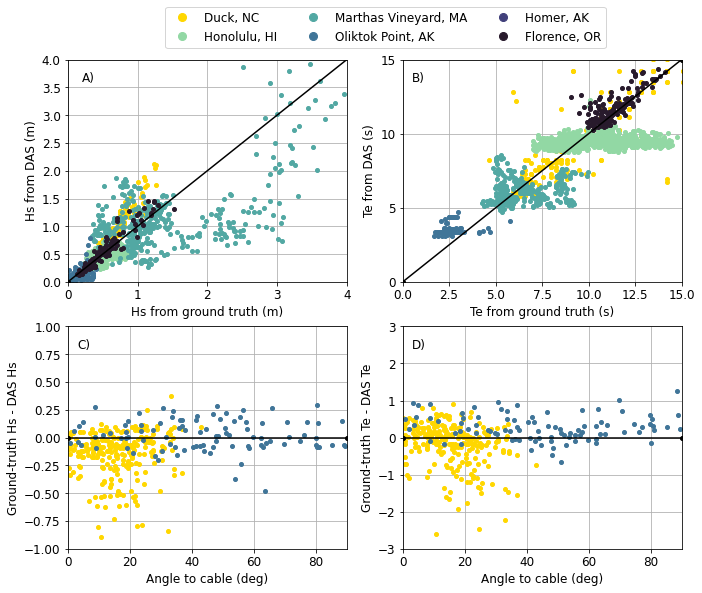

In [9]:
plt.rc('font', size=12)
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linestyle'] = 'none'
plt.rcParams['lines.marker'] = '.'

fig,ax = plt.subplots(2,2,figsize=(11,9))
ax= ax.ravel()
ax[0].plot(duc_hs_pre,duc_hs_das,c = 'gold')
ax[0].plot(hs_pre,hs_das,c = clrs[1,:])
ax[0].plot(hs_adcp,hs_mv,c = clrs[2,:])
ax[0].plot(hs_swift,hs_oli,c = clrs[3,:])
ax[0].plot(hs_hombuoy,hs_hom,c = clrs[4,:])
ax[0].plot(hs_pre_flo,hs_das_flo,c = clrs[5,:])
ax[0].plot((0,6),(0,6),'k',linestyle='-')
ax[0].set_xlabel('Hs from ground truth (m)')
ax[0].set_ylabel('Hs from DAS (m)')
ax[0].set_xlim([0,4])
ax[0].set_ylim([0,4])
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0].grid(which='major', axis='both')

ax[1].plot(duc_tp_pre,duc_tp_das,c = 'gold',label='Duck, NC')
ax[1].plot(te_pre,te_das,c = clrs[1,:],label='Honolulu, HI')
ax[1].plot(te_adcp,te_mv,c = clrs[2,:],label='Martha''s Vineyard, MA')
ax[1].plot(tp_swift,tp_oli,c = clrs[3,:],label='Oliktok Point, AK')
ax[1].plot(te_hombuoy,te_hom,c = clrs[4,:],label='Homer, AK')
ax[1].plot(te_pre_flo,te_das_flo,c = clrs[5,:],label='Florence, OR')
ax[1].set_xlabel('Te from ground truth (s)')
ax[1].set_ylabel('Te from DAS (s)')
ax[1].plot((0,15),(0,15),'k',linestyle='-')
ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax[1].set_xlim([0,15])
ax[1].set_ylim([0,15])
ax[1].legend(loc=(-0.85,1.05),ncol=3,markerscale=2)
ax[1].grid(which='major', axis='both')


ax[2].plot(duc_meanDir,hs_duck_dif,c = 'gold')
ax[2].plot(MWD,hs_hom_dif,c = clrs[4,:])
ax[2].plot(dir_swift,hs_oli_dif,c = clrs[3,:])
ax[2].set_xlabel('Angle to cable (deg)')
ax[2].set_ylabel('Ground-truth Hs - DAS Hs')
ax[2].axhline(y=0,c='k',linestyle='-')
ax[2].set_ylim([-1,1])
ax[2].set_xlim([0,90])
ax[2].grid(which='major', axis='both')

ax[3].plot(duc_meanDir,te_duck_dif,c = 'gold')
ax[3].plot(MWD,te_hom_dif,c = clrs[4,:])
ax[3].plot(dir_swift,te_oli_dif,c = clrs[3,:])
ax[3].set_xlabel('Angle to cable (deg)')
ax[3].set_ylabel('Ground-truth Te - DAS Te')
ax[3].axhline(y=0,c='k',linestyle='-')
ax[3].set_ylim([-3,3])
ax[3].set_xlim([0,90])
ax[3].grid(which='major', axis='both')

ax[0].text(0.2,3.6, 'A)')
ax[1].text(0.5,13.5, 'B)')
ax[2].text(3,0.8, 'C)')
ax[3].text(3,2.4, 'D)')

# plt.savefig('/Users/hglover/Downloads/ScatterHT_all.png')